In [1]:
import sys
sys.path.append('/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes')
import numpy as np
from process_file import process_file_modif
from process_file import process_file_modif_varios
import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate
from interaccion_no_normalizada import batch_vecinos

In [2]:
#en marco mundo

eth_univ_pix_path = '../data1/eth/univ/mundo/mun_pos.csv'
class parameters:
    def __init__(self):
        self.person_max = 42 # 8
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = True
        self.kp_num = 18
        self.add_kp = False
     

In [3]:
# Cargamos los argumentos
arguments = parameters()

# Procesamos los datos de eth_univ
data_eth_univ = process_file_modif(eth_univ_pix_path, arguments, ',')

El numero total de ejemplos
339


In [4]:
#vector = batch_vecinos(data_eth_univ['obs_person'],data_eth_univ['key_idx'],data_eth_univ['obs_traj'],arguments)
#np.save('flujo_bien_non_eth_univ_total_mundo_12.npy',vector )

# Cargamos el flujo optico

In [5]:
vector_flujo = 'flujo_bien_non_eth_univ_total_mundo_12.npy'
flujo = np.load(vector_flujo)
flujo.shape

(339, 8, 64)

# Agregamos el flujo optico

In [6]:
data_eth_univ.update({
    "obs_flujo": flujo,
        })

# Division de los conjuntos de datos

In [7]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba
prob = 0.7 
# La cantidad total de listas de tam 8 
ndata = len(data_eth_univ[list(data_eth_univ.keys())[2]])
idx = random.sample(range(ndata), ndata)
long1 = int(ndata*prob)
long2 = int(ndata*0.2)
long3 = int(ndata-long1-long2)

idx_train = idx[0:long1]
idx_test = idx[long1:long1+long2]
idx_val = idx[long1+long2:]

# conjunto de entrenamiento
data1 = {
     "obs_traj": data_eth_univ["obs_traj"][idx_train],
     "obs_traj_rel": data_eth_univ["obs_traj_rel"][idx_train],
    
     "pred_traj": data_eth_univ["pred_traj"][idx_train],
     "pred_traj_rel": data_eth_univ["pred_traj_rel"][idx_train],
    
     "key_idx": data_eth_univ["key_idx"][[idx_train]],
    
     
     "obs_flujo" : data_eth_univ["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}

# Conjunto de prueba
data2 = {
     "obs_traj": data_eth_univ["obs_traj"][idx_test],
     "obs_traj_rel": data_eth_univ["obs_traj_rel"][idx_test],
     "pred_traj": data_eth_univ["pred_traj"][idx_test],
     "pred_traj_rel": data_eth_univ["pred_traj_rel"][idx_test],
     "key_idx": data_eth_univ["key_idx"][[idx_test]],
     "obs_flujo" : data_eth_univ["obs_flujo"][idx_test],
     #"pred_kp": data_pets["pred_kp"][idx_test],
     #"obs_person": data_pets["obs_person"][idx_test]
}

# conjunto de validacion
data3 ={
     "obs_traj": data_eth_univ["obs_traj"][idx_val],
     "obs_traj_rel": data_eth_univ["obs_traj_rel"][idx_val],
     "pred_traj": data_eth_univ["pred_traj"][idx_val],
     "pred_traj_rel": data_eth_univ["pred_traj_rel"][idx_val],
     "key_idx": data_eth_univ["key_idx"][[idx_val]],
     "obs_flujo" : data_eth_univ["obs_flujo"][idx_val],
     #"pred_kp": data_pets["pred_kp"][idx_val],
     #"obs_person": data_pets["obs_person"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data2[list(data2.keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))
#print("data4: "+ str(len(data4[list(data4.keys())[0]])))


data_train: 237
data_test: 67
data_val: 35


/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will re

# Se guardan las diviones de los datos

In [8]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_non_eth_univ_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_non_eth_univ_12.pickle","wb")
pickle.dump(data2, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_non_eth_univ_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# parametrs del modelo

In [9]:
class parameters1:
    def __init__(self, add_kp = None, add_social=None, train_num_examples=None):
        # -----------------
        # Similar a como se procesaron los datos
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        #self.maxNumPed = 8
        #self.grid_size = 4
        #self.neighborhood_size = 32
        #self.dimensions = [768,576]
        #self.limites=[-15.88,11.56,-19.09,5.99]
        #self.bound=[0.7,0.5]
        # ------------------
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Entrenamos el modelo

In [10]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True,train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('sin_KP_NoN_EthUniv_social12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"] =results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('sin_KP_NoN_EthUniv_social-best12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('sin_KP_NoN_EthUniv_social12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))
       
    

W1227 09:50:24.755260 140370843436800 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:13: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W1227 09:50:24.779964 140370843436800 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:31: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1227 09:50:24.796067 140370843436800 deprecation.py:323] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:70: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W1227 09:50:24.798320 140370843436800 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:72: The name tf.nn.rnn_cell.DropoutW

12
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/2 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 2/2 [00:00<00:00,  4.72it/s]

{'ade': 2.269326, 'fde': 3.71842}
	 last loss:-1.000000000, eval on validation:['ade: 2.269326', 'fde: 3.71842'], (best ade:999999 at step -1) 
	 saving best model...
	 done.


  8%|▊         | 1/12 [00:00<00:01,  8.42it/s]

('Epoca 2.', 'lr:', 0.002)


 17%|█▋        | 2/12 [00:00<00:00, 14.62it/s]

('Epoca 3.', 'lr:', 0.0017000001)


 17%|█▋        | 2/12 [00:00<00:00, 18.24it/s]

('Epoca 4.', 'lr:', 0.0017000001)


 17%|█▋        | 2/12 [00:00<00:00, 14.87it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  8%|▊         | 1/12 [00:00<00:01,  9.30it/s]

('Epoca 6.', 'lr:', 0.0014450002)


 17%|█▋        | 2/12 [00:00<00:00, 15.00it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  8%|▊         | 1/12 [00:00<00:01,  8.24it/s]

('Epoca 8.', 'lr:', 0.0012282502)


  8%|▊         | 1/12 [00:00<00:01,  8.78it/s]

('Epoca 9.', 'lr:', 0.0010440127)


  8%|▊         | 1/12 [00:00<00:01,  9.03it/s]

('Epoca 10.', 'lr:', 0.0010440127)


 25%|██▌       | 3/12 [00:00<00:00, 26.86it/s]

('Epoca 11.', 'lr:', 0.0008874108)


 17%|█▋        | 2/12 [00:00<00:00, 16.11it/s]

('Epoca 12.', 'lr:', 0.0007542992)


 25%|██▌       | 3/12 [00:00<00:00, 26.25it/s]

('Epoca 13.', 'lr:', 0.0007542992)


 17%|█▋        | 2/12 [00:00<00:00, 14.35it/s]

('Epoca 14.', 'lr:', 0.0006411543)


  8%|▊         | 1/12 [00:00<00:01,  8.73it/s]

('Epoca 15.', 'lr:', 0.0006411543)


 25%|██▌       | 3/12 [00:00<00:00, 20.26it/s]

('Epoca 16.', 'lr:', 0.0005449812)


  8%|▊         | 1/12 [00:00<00:01,  8.37it/s]

('Epoca 17.', 'lr:', 0.0005449812)


 17%|█▋        | 2/12 [00:00<00:00, 15.89it/s]

('Epoca 18.', 'lr:', 0.00046323403)


 17%|█▋        | 2/12 [00:00<00:00, 18.92it/s]

('Epoca 19.', 'lr:', 0.00046323403)


  8%|▊         | 1/12 [00:00<00:01,  9.35it/s]

('Epoca 20.', 'lr:', 0.00039374892)


  8%|▊         | 1/12 [00:00<00:01,  9.89it/s]

('Epoca 21.', 'lr:', 0.00039374892)


  8%|▊         | 1/12 [00:00<00:01,  8.23it/s]

('Epoca 22.', 'lr:', 0.0003346866)


 17%|█▋        | 2/12 [00:00<00:00, 17.83it/s]

('Epoca 23.', 'lr:', 0.00028448363)


 25%|██▌       | 3/12 [00:00<00:00, 23.47it/s]

('Epoca 24.', 'lr:', 0.00028448363)


 17%|█▋        | 2/12 [00:00<00:00, 14.91it/s]

('Epoca 25.', 'lr:', 0.0002418111)


 92%|█████████▏| 11/12 [00:00<00:00, 20.26it/s]


	saving model 300...
	done
Evaluating


100%|##########| 2/2 [00:00<00:00, 60.57it/s]

{'ade': 1.1153669, 'fde': 2.4745781}
	 last loss:0.002462082, eval on validation:['ade: 1.1153669', 'fde: 2.4745781'], (best ade:2.269326 at step 1) 
	 saving best model...
	 done.


 17%|█▋        | 2/12 [00:00<00:00, 16.57it/s]

('Epoca 26.', 'lr:', 0.0002418111)


  8%|▊         | 1/12 [00:00<00:01,  9.33it/s]

('Epoca 27.', 'lr:', 0.00020553943)


 25%|██▌       | 3/12 [00:00<00:00, 25.66it/s]

('Epoca 28.', 'lr:', 0.00020553943)


 25%|██▌       | 3/12 [00:00<00:00, 24.61it/s]

('Epoca 29.', 'lr:', 0.00017470852)


 17%|█▋        | 2/12 [00:00<00:00, 15.35it/s]

('Epoca 30.', 'lr:', 0.00017470852)


 25%|██▌       | 3/12 [00:00<00:00, 26.31it/s]

('Epoca 31.', 'lr:', 0.00014850224)


 25%|██▌       | 3/12 [00:00<00:00, 24.40it/s]

('Epoca 32.', 'lr:', 0.00014850224)


 25%|██▌       | 3/12 [00:00<00:00, 23.70it/s]

('Epoca 33.', 'lr:', 0.0001262269)


  8%|▊         | 1/12 [00:00<00:01,  9.18it/s]

('Epoca 34.', 'lr:', 0.00010729288)


 17%|█▋        | 2/12 [00:00<00:00, 14.91it/s]

('Epoca 35.', 'lr:', 0.00010729288)


  8%|▊         | 1/12 [00:00<00:01,  9.06it/s]

('Epoca 36.', 'lr:', 9.119895e-05)


  8%|▊         | 1/12 [00:00<00:01,  9.56it/s]

('Epoca 37.', 'lr:', 9.119895e-05)


  8%|▊         | 1/12 [00:00<00:01,  9.62it/s]

('Epoca 38.', 'lr:', 7.751911e-05)


  8%|▊         | 1/12 [00:00<00:01,  8.23it/s]

('Epoca 39.', 'lr:', 7.751911e-05)


  8%|▊         | 1/12 [00:00<00:01,  8.77it/s]

('Epoca 40.', 'lr:', 6.589125e-05)


 25%|██▌       | 3/12 [00:00<00:00, 26.59it/s]

('Epoca 41.', 'lr:', 6.589125e-05)


  8%|▊         | 1/12 [00:00<00:01,  7.77it/s]

('Epoca 42.', 'lr:', 5.600756e-05)


  8%|▊         | 1/12 [00:00<00:01,  8.56it/s]

('Epoca 43.', 'lr:', 5.600756e-05)


 17%|█▋        | 2/12 [00:00<00:00, 19.11it/s]

('Epoca 44.', 'lr:', 4.7606427e-05)


 25%|██▌       | 3/12 [00:00<00:00, 24.52it/s]

('Epoca 45.', 'lr:', 4.0465464e-05)


 17%|█▋        | 2/12 [00:00<00:00, 15.45it/s]

('Epoca 46.', 'lr:', 4.0465464e-05)


 25%|██▌       | 3/12 [00:00<00:00, 22.15it/s]

('Epoca 47.', 'lr:', 3.4395645e-05)


 17%|█▋        | 2/12 [00:00<00:00, 12.31it/s]

('Epoca 48.', 'lr:', 3.4395645e-05)


  8%|▊         | 1/12 [00:00<00:01,  8.21it/s]

('Epoca 49.', 'lr:', 2.92363e-05)


  8%|▊         | 1/12 [00:00<00:01,  8.14it/s]

('Epoca 50.', 'lr:', 2.92363e-05)


 92%|█████████▏| 11/12 [00:00<00:00, 13.40it/s]W1227 09:51:01.935976 140370843436800 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/2 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



  0%|          | 0/12 [00:00<?, ?it/s]

{'ade': 1.1348875, 'fde': 2.5398538}
	 last loss:0.001988280, eval on validation:['ade: 1.1348875', 'fde: 2.5398538'], (best ade:1.1153669 at step 300) 
('Epoca 51.', 'lr:', 2.4850853e-05)


 17%|█▋        | 2/12 [00:00<00:00, 17.61it/s]

('Epoca 52.', 'lr:', 2.4850853e-05)


 17%|█▋        | 2/12 [00:00<00:00, 17.57it/s]

('Epoca 53.', 'lr:', 2.1123227e-05)


 25%|██▌       | 3/12 [00:00<00:00, 24.72it/s]

('Epoca 54.', 'lr:', 2.1123227e-05)


 17%|█▋        | 2/12 [00:00<00:00, 18.37it/s]

('Epoca 55.', 'lr:', 1.7954744e-05)


  8%|▊         | 1/12 [00:00<00:01,  8.77it/s]

('Epoca 56.', 'lr:', 1.5261532e-05)


 17%|█▋        | 2/12 [00:00<00:00, 16.35it/s]

('Epoca 57.', 'lr:', 1.5261532e-05)


 25%|██▌       | 3/12 [00:00<00:00, 23.54it/s]

('Epoca 58.', 'lr:', 1.2972303e-05)


 17%|█▋        | 2/12 [00:00<00:00, 14.35it/s]

('Epoca 59.', 'lr:', 1.2972303e-05)


 17%|█▋        | 2/12 [00:00<00:00, 17.52it/s]

('Epoca 60.', 'lr:', 1.1026457e-05)


  8%|▊         | 1/12 [00:00<00:01,  9.86it/s]

('Epoca 61.', 'lr:', 1.1026457e-05)


  8%|▊         | 1/12 [00:00<00:01,  8.42it/s]

('Epoca 62.', 'lr:', 9.37249e-06)


 25%|██▌       | 3/12 [00:00<00:00, 23.14it/s]

('Epoca 63.', 'lr:', 9.37249e-06)


  8%|▊         | 1/12 [00:00<00:01,  9.75it/s]

('Epoca 64.', 'lr:', 7.966617e-06)


  8%|▊         | 1/12 [00:00<00:01,  7.56it/s]

('Epoca 65.', 'lr:', 7.966617e-06)


  8%|▊         | 1/12 [00:00<00:01,  8.62it/s]

('Epoca 66.', 'lr:', 6.7716246e-06)


 17%|█▋        | 2/12 [00:00<00:00, 15.36it/s]

('Epoca 67.', 'lr:', 5.7558805e-06)


  8%|▊         | 1/12 [00:00<00:01,  8.30it/s]

('Epoca 68.', 'lr:', 5.7558805e-06)


 25%|██▌       | 3/12 [00:00<00:00, 22.08it/s]

('Epoca 69.', 'lr:', 4.8924985e-06)


 25%|██▌       | 3/12 [00:00<00:00, 25.26it/s]

('Epoca 70.', 'lr:', 4.8924985e-06)


 17%|█▋        | 2/12 [00:00<00:00, 13.42it/s]

('Epoca 71.', 'lr:', 4.158624e-06)


 25%|██▌       | 3/12 [00:00<00:00, 22.50it/s]

('Epoca 72.', 'lr:', 4.158624e-06)


 17%|█▋        | 2/12 [00:00<00:00, 18.17it/s]

('Epoca 73.', 'lr:', 3.5348305e-06)


 17%|█▋        | 2/12 [00:00<00:00, 17.15it/s]

('Epoca 74.', 'lr:', 3.5348305e-06)


 17%|█▋        | 2/12 [00:00<00:00, 13.42it/s]

('Epoca 75.', 'lr:', 3.004606e-06)


 83%|████████▎ | 10/12 [00:00<00:00, 14.60it/s]

	saving model 900...



  0%|          | 0/12 [00:00<?, ?it/s]

	done
Evaluating
{'ade': 1.1282793, 'fde': 2.5192914}
	 last loss:0.001630157, eval on validation:['ade: 1.1282793', 'fde: 2.5192914'], (best ade:1.1153669 at step 300) 
('Epoca 76.', 'lr:', 3.004606e-06)


 25%|██▌       | 3/12 [00:00<00:00, 23.55it/s]

('Epoca 77.', 'lr:', 2.5539152e-06)


  8%|▊         | 1/12 [00:00<00:01,  8.76it/s]

('Epoca 78.', 'lr:', 2.170828e-06)


  8%|▊         | 1/12 [00:00<00:01,  8.73it/s]

('Epoca 79.', 'lr:', 2.170828e-06)


 17%|█▋        | 2/12 [00:00<00:00, 18.03it/s]

('Epoca 80.', 'lr:', 1.8452038e-06)


 25%|██▌       | 3/12 [00:00<00:00, 22.97it/s]

('Epoca 81.', 'lr:', 1.8452038e-06)


  8%|▊         | 1/12 [00:00<00:01,  8.83it/s]

('Epoca 82.', 'lr:', 1.5684233e-06)


 17%|█▋        | 2/12 [00:00<00:00, 16.86it/s]

('Epoca 83.', 'lr:', 1.5684233e-06)


  8%|▊         | 1/12 [00:00<00:01,  9.37it/s]

('Epoca 84.', 'lr:', 1.3331598e-06)


 17%|█▋        | 2/12 [00:00<00:00, 19.19it/s]

('Epoca 85.', 'lr:', 1.3331598e-06)


 17%|█▋        | 2/12 [00:00<00:00, 14.50it/s]

('Epoca 86.', 'lr:', 1.1331858e-06)


 25%|██▌       | 3/12 [00:00<00:00, 22.57it/s]

('Epoca 87.', 'lr:', 1.1331858e-06)


 17%|█▋        | 2/12 [00:00<00:00, 17.03it/s]

('Epoca 88.', 'lr:', 9.63208e-07)


 17%|█▋        | 2/12 [00:00<00:00, 14.84it/s]

('Epoca 89.', 'lr:', 8.187269e-07)


 17%|█▋        | 2/12 [00:00<00:00, 14.84it/s]

('Epoca 90.', 'lr:', 8.187269e-07)


 25%|██▌       | 3/12 [00:00<00:00, 21.46it/s]

('Epoca 91.', 'lr:', 6.9591783e-07)


  8%|▊         | 1/12 [00:00<00:01,  8.46it/s]

('Epoca 92.', 'lr:', 6.9591783e-07)


 25%|██▌       | 3/12 [00:00<00:00, 25.46it/s]

('Epoca 93.', 'lr:', 5.915302e-07)


  8%|▊         | 1/12 [00:00<00:01,  9.53it/s]

('Epoca 94.', 'lr:', 5.915302e-07)


  8%|▊         | 1/12 [00:00<00:01,  8.80it/s]

('Epoca 95.', 'lr:', 5.028007e-07)


 17%|█▋        | 2/12 [00:00<00:00, 17.93it/s]

('Epoca 96.', 'lr:', 5.028007e-07)


  8%|▊         | 1/12 [00:00<00:01,  8.24it/s]

('Epoca 97.', 'lr:', 4.2738057e-07)


 17%|█▋        | 2/12 [00:00<00:00, 16.36it/s]

('Epoca 98.', 'lr:', 4.2738057e-07)


  8%|▊         | 1/12 [00:00<00:01,  9.60it/s]

('Epoca 99.', 'lr:', 3.632735e-07)


  8%|▊         | 1/12 [00:00<00:01,  9.14it/s]

('Epoca 100.', 'lr:', 3.087825e-07)


  0%|          | 0/2 [00:00<?, ?it/s]

	saving model 1200...
	done
Evaluating



100%|██████████| 12/12 [00:00<00:00, 14.60it/s]A

{'ade': 1.1277776, 'fde': 2.5179002}
	 last loss:0.001708078, eval on validation:['ade: 1.1277776', 'fde: 2.5179002'], (best ade:1.1153669 at step 300) 
best eval on val ade: 1.1153669 at 300 step y fde es 2.4745781 


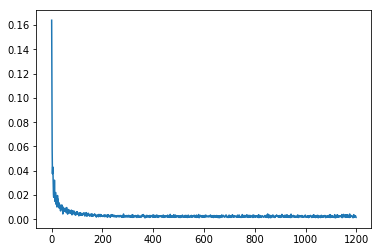

In [11]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.show()

In [12]:
# Guardamos el ultimo modelo
checkpoint_path_model = os.path.join('sin_KP_NoN_EthUniv_social12_F', 'model.ckpt')
saver.save(sess,checkpoint_path_model , global_step = global_step)

'sin_KP_NoN_EthUniv_social12_F/model.ckpt-1200'

# Restauramos ls modelos

In [13]:
#Ultimo Modelo
path_model = 'sin_KP_NoN_EthUniv_social12_F/model.ckpt-1200'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

W1227 09:52:54.758253 140370843436800 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
100%|##########| 4/4 [00:00<00:00, 62.73it/s]

Evaluating
{'ade': 0.9961667, 'fde': 1.990893}


In [15]:
#Modelo12
path_model = 'sin_KP_NoN_EthUniv_social12/model.ckpt-1200'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

100%|##########| 4/4 [00:00<00:00, 35.37it/s]

Evaluating
{'ade': 0.9961634, 'fde': 1.9908812}


In [17]:
# Mejor Modelo
path_model = 'sin_KP_NoN_EthUniv_social-best12/model_best.ckpt-300'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

100%|##########| 4/4 [00:00<00:00, 62.52it/s]

Evaluating
{'ade': 0.987769, 'fde': 1.9639252}
